In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np, os
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")
from ad_utils import *

print(torch.cuda.device_count())
cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda0
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)
X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(faulty_data, faulty_label, test_size=0.2, random_state=42, shuffle=True)

2
NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


In [2]:
# ===============================
# MADGAN ARCHITECTURE FOR MULTIVARIATE TIME SERIES ANOMALY DETECTION
# ===============================

class MemoryEfficientMADGAN(nn.Module):
    def __init__(self, input_dim, latent_dim=64, sequence_length=None):
        super(MemoryEfficientMADGAN, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.sequence_length = sequence_length or input_dim
        
        # Memory-efficient Generator with residual connections
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, input_dim),
            nn.Tanh()
        )
        
        # Lightweight Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
        # Encoder for anomaly detection
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, latent_dim)
        )
    
    def forward(self, x):
        return self.discriminator(x)
    
    def generate(self, z):
        return self.generator(z)
    
    def encode(self, x):
        return self.encoder(x)

# Memory-efficient training function
def train_madgan_memory_efficient(model, normal_data, epochs=100, batch_size=32, lr=0.0002):
    model.to(device)
    
    # Optimizers with gradient clipping for stability
    optimizer_G = optim.Adam(model.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_E = optim.Adam(model.encoder.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    # Create DataLoader for memory efficiency
    normal_tensor = torch.FloatTensor(normal_data)
    dataset = TensorDataset(normal_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0
        
        for batch_data, in dataloader:
            batch_data = batch_data.to(device, non_blocking=True)
            batch_size_actual = batch_data.size(0)
            
            # Clear cache periodically
            if num_batches % 10 == 0:
                torch.cuda.empty_cache()
            
            # Train Discriminator
            optimizer_D.zero_grad()
            
            # Real data
            real_labels = torch.ones(batch_size_actual, 1).to(device)
            real_output = model.discriminator(batch_data)
            d_loss_real = criterion(real_output, real_labels)
            
            # Fake data
            z = torch.randn(batch_size_actual, model.latent_dim).to(device)
            fake_data = model.generator(z).detach()
            fake_labels = torch.zeros(batch_size_actual, 1).to(device)
            fake_output = model.discriminator(fake_data)
            d_loss_fake = criterion(fake_output, fake_labels)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.discriminator.parameters(), 1.0)
            optimizer_D.step()
            
            # Train Generator and Encoder
            optimizer_G.zero_grad()
            optimizer_E.zero_grad()
            
            # Generator loss
            z = torch.randn(batch_size_actual, model.latent_dim).to(device)
            fake_data = model.generator(z)
            fake_output = model.discriminator(fake_data)
            g_loss_adv = criterion(fake_output, real_labels)
            
            # Reconstruction loss
            encoded = model.encoder(batch_data)
            reconstructed = model.generator(encoded)
            reconstruction_loss = mse_loss(reconstructed, batch_data)
            
            # Feature matching loss
            with torch.no_grad():
                real_features = model.discriminator(batch_data)
            fake_features = model.discriminator(fake_data)
            feature_loss = mse_loss(fake_features, real_features)
            
            # Combined loss
            g_loss = g_loss_adv + 10 * reconstruction_loss + 5 * feature_loss
            g_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.generator.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), 1.0)
            
            optimizer_G.step()
            optimizer_E.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            num_batches += 1
        
        if epoch % 20 == 0:
            print(f"Epoch [{epoch}/{epochs}] D_Loss: {epoch_d_loss/num_batches:.4f}, G_Loss: {epoch_g_loss/num_batches:.4f}")
    
    return model

# Anomaly detection function
def detect_anomalies_madgan(model, test_data, threshold_percentile=95):
    model.eval()
    anomaly_scores = []
    
    with torch.no_grad():
        test_tensor = torch.FloatTensor(test_data).to(device)
        
        # Reconstruction-based anomaly score
        encoded = model.encoder(test_tensor)
        reconstructed = model.generator(encoded)
        reconstruction_errors = torch.mean((test_tensor - reconstructed) ** 2, dim=1)
        
        # Discriminator-based anomaly score
        discriminator_scores = model.discriminator(test_tensor).squeeze()
        
        # Combined anomaly score
        combined_scores = reconstruction_errors + (1 - discriminator_scores)
        anomaly_scores = combined_scores.cpu().numpy()
    
    # Dynamic threshold
    threshold = np.percentile(anomaly_scores, threshold_percentile)
    predictions = (anomaly_scores > threshold).astype(int)
    
    return predictions, anomaly_scores, threshold

# Initialize and train the model
print("Initializing Memory-Efficient MADGAN...")

# Flatten the data to 2D if it's 3D
if len(X_train_normal.shape) == 3:
    print(f"Original data shape: {X_train_normal.shape}")
    X_train_flattened = X_train_normal.reshape(X_train_normal.shape[0], -1)
    print(f"Flattened data shape: {X_train_flattened.shape}")
    input_dim = X_train_flattened.shape[1]
else:
    X_train_flattened = X_train_normal
    input_dim = X_train_normal.shape[1]

print(f"Input dimension: {input_dim}")
madgan_model = MemoryEfficientMADGAN(input_dim=input_dim, latent_dim=64)

print(f"Training MADGAN on {X_train_flattened.shape[0]} normal samples...")
trained_madgan = train_madgan_memory_efficient(
    madgan_model, 
    X_train_flattened, 
    epochs=200, 
    batch_size=32,
    lr=0.0002
)

# Generate synthetic data for downstream tasks
print("Generating synthetic normal data...")
trained_madgan.eval()
with torch.no_grad():
    num_samples = len(X_train_normal)  # Memory-efficient generation
    z = torch.randn(num_samples, trained_madgan.latent_dim).to(device)
    memory_generated_data = trained_madgan.generator(z).cpu().numpy()


# Reshape generated data to match original input shape (n, 4500, 14)
memory_generated_data = memory_generated_data.reshape(-1, X_train_normal.shape[1], X_train_normal.shape[2])

print(f"Generated data shape: {memory_generated_data.shape}")
torch.cuda.empty_cache()  # Clear GPU memory

Initializing Memory-Efficient MADGAN...
Original data shape: (552, 4500, 14)
Flattened data shape: (552, 63000)
Input dimension: 63000
Training MADGAN on 552 normal samples...
Epoch [0/200] D_Loss: 0.0911, G_Loss: 19.2145
Epoch [20/200] D_Loss: 0.1735, G_Loss: 15.5135
Epoch [40/200] D_Loss: 0.3576, G_Loss: 15.6007
Epoch [60/200] D_Loss: 0.1475, G_Loss: 16.4387
Epoch [80/200] D_Loss: 0.1572, G_Loss: 15.8749
Epoch [100/200] D_Loss: 0.2329, G_Loss: 13.5864
Epoch [120/200] D_Loss: 0.2771, G_Loss: 12.9644
Epoch [140/200] D_Loss: 0.2064, G_Loss: 11.3539
Epoch [160/200] D_Loss: 0.1676, G_Loss: 11.5266
Epoch [180/200] D_Loss: 0.1764, G_Loss: 11.3452
Generating synthetic normal data...
Generated data shape: (552, 4500, 14)


In [3]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train_normal[:100]  # Use 100 samples for testing
test_generated = memory_generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 1.0000]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 1.0000]
FID Score: 18.6340

🎉 SUCCESS! FID Score: 18.6340
Quality Assessment: Good



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 138
Faulty samples: 37
Generated samples: 552
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 110
Fold 1 - Train faulty: 30
Fold 1 - Test: 35 (28 normal, 7 faulty)
Fold 1 - Augmented normal data: 662 samples
Processing data through feature extraction...
Processing 662 samples with multi-channel approach...
Processing 30 samples with multi-channel approach...
Processing 35 samples with multi-channel approach...
Training autoencoder...
Training Binary Classification SVM...

Fold 1 Results:
--------------------------------------------------
F1_Threshold       | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Accuracy_Threshold | Acc: 0.9143 | Prec: 0.7500 | Rec: 0.8571 | F1: 0.8000
Binary_SVM         | Acc: 0.9143 | Prec: 1.0000 | Rec: 0.5714 | F1: 0.7273

========================= FOLD 2/5 =========================
Fold 2 - Train normal: 110
Fo

/home/maddie/SmartIoT-2025/GANs models/MADGANs/../ad_utils.py:879: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(methods, rotation=45, ha='right')


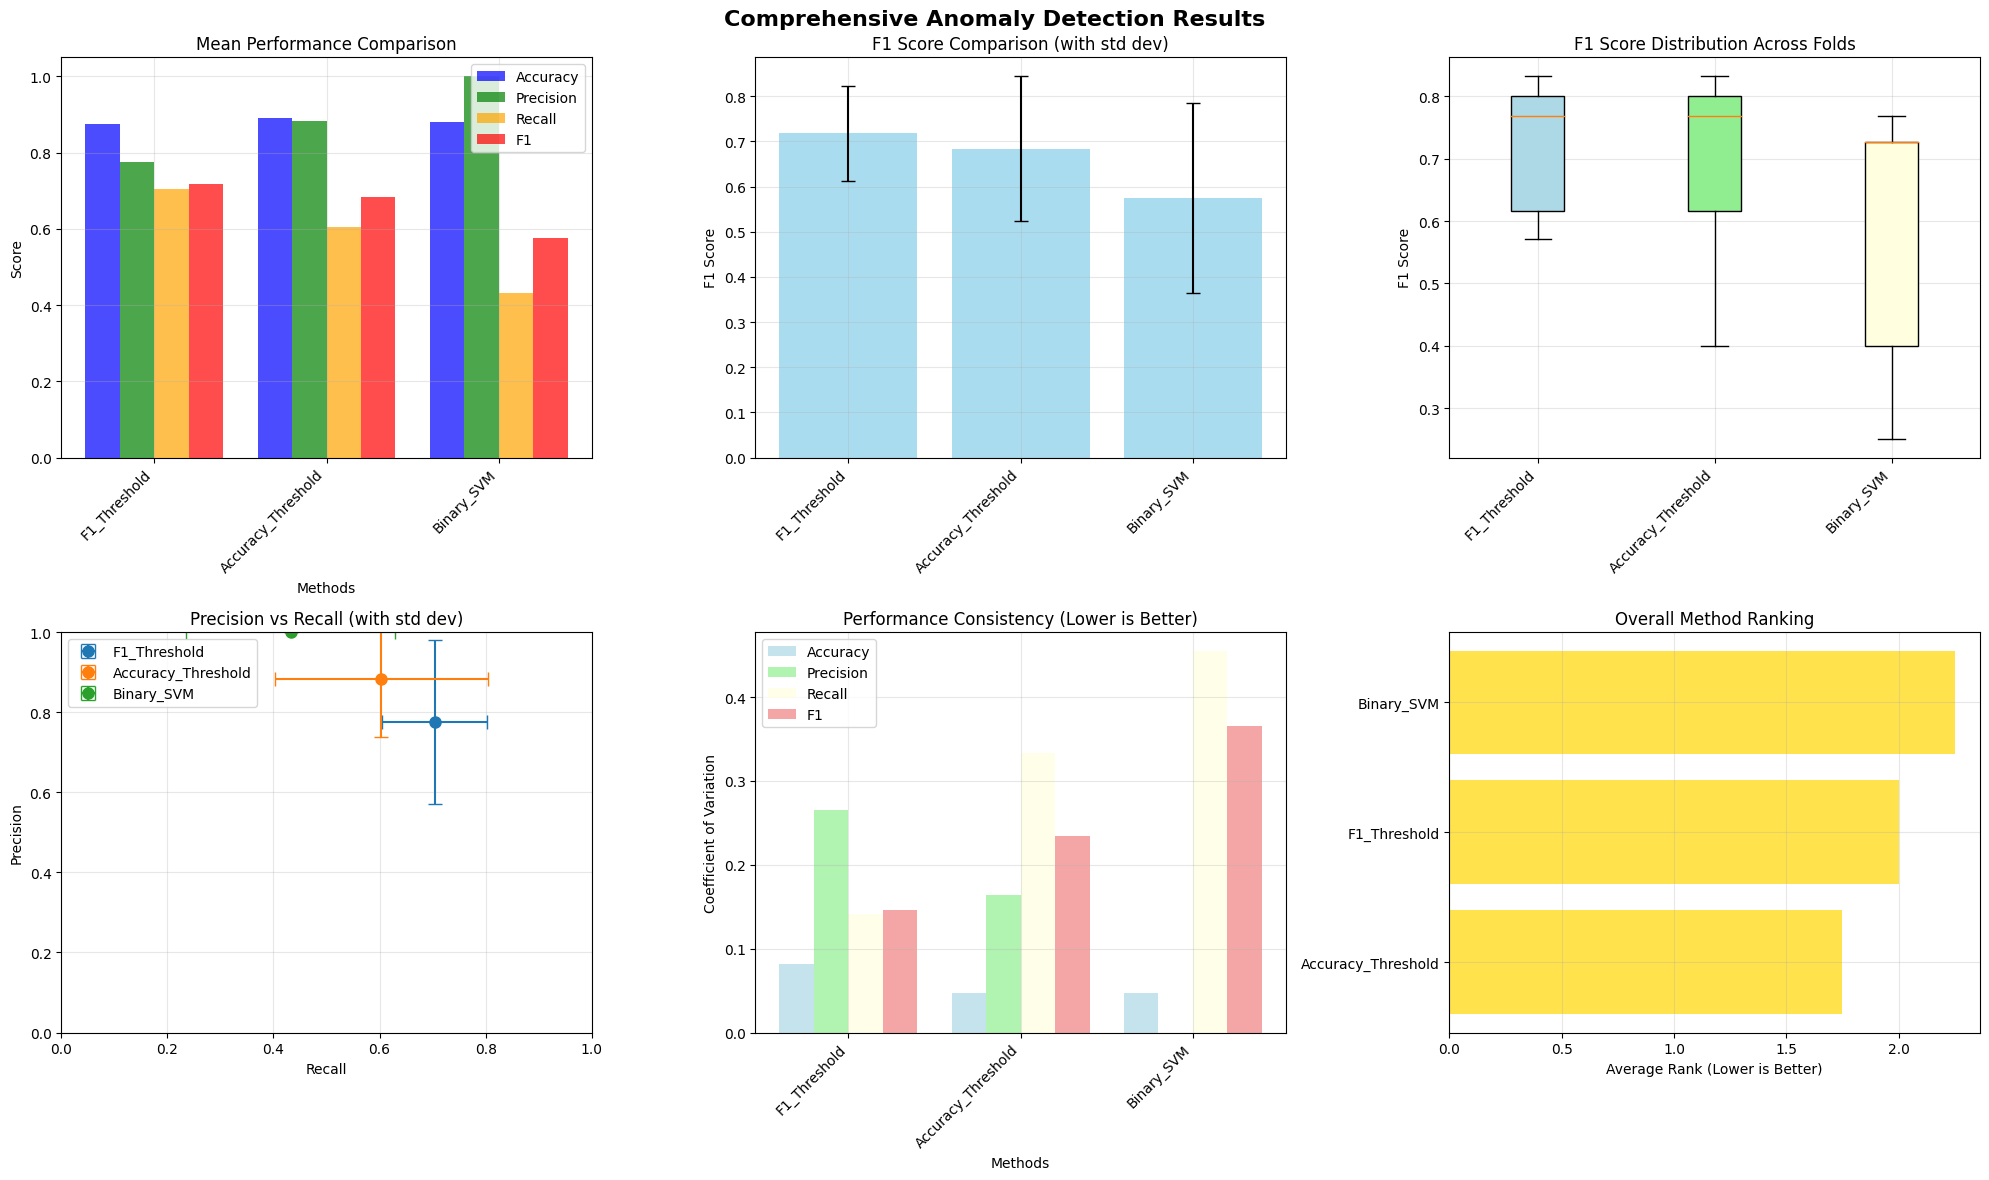


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.7179)
   • Best Accuracy: Accuracy_Threshold (0.8914)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : High Precision (fewer false alarms), Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • Binary_SVM            : High Precision (fewer false alarms), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8742857142857143,
    'std': 0.07137140569598167,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.7428571428571429]},
   'precision': {'mean': 0.7756410256410257,
    'std': 0.20584809575821847,
    'values': [0.75, 0.6666666666666666, 1.0, 1.0, 0.46153846153846156]},
   'recall': {'mean': 0.7035714285714285,
    'std': 0.09948848769417226,
    'values': [0.8571428571428571,
     0.5714285714285714,
     0.7142857142857143,
     0.625,
     0.75]},
   'f1': {'mean': 0.7178754578754578,
    'std': 0.10455944985823414,
    'values': [0.7999999999999999,
     0.6153846153846153,
     0.8333333333333333,
     0.7692307692307693,
     0.5714285714285714]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8914285714285715,
    'std': 0.04199125273342589,
    'values': [0.9142857142857143,
     0.8571428571428571,
     0.9428571428571428,
     0.9142857142857143,
     0.8285714285714

In [5]:
run_comprehensive_cross_validation_experiment(X_test_normal, X_test_faulty, device, memory_generated_data, batch_size=32)